In [1]:
using Interpolations
using Dierckx
using NPZ
using DifferentialEquations
using Plots
using PyPlot 
import PyPlot
using LaTeXStrings
using Statistics
using PyCall

In [110]:
using Sundials
using QuadGK

In [430]:
na = CartesianIndex();

In [441]:
Plots.contour(pxr.X[1:end,1,1],pxr.Z[1:end,1,1].',B1[:,:,1,1])

LoadError: [91msyntax: the ".'" operator is discontinued[39m

## Load and Spline magnetic field

In [112]:
pxr = pyimport("pixie_read_st")

PyObject <module 'pixie_read_st' from '/users/giannis_kx/python_pixie/pixie_read_st.py'>

In [113]:
filepath = "/net/scratch3/giannis_kx/pixie3d/iter/iter3d/db_tear/dt_sh_m3_n2.scratch/pixie3d.h5"

"/net/scratch3/giannis_kx/pixie3d/iter/iter3d/db_tear/dt_sh_m3_n2.scratch/pixie3d.h5"

In [114]:
pxr.pixieload(filepath)

In [115]:
B1c = pxr.load_array(1,0,110,115);
B2c = pxr.load_array(1,1,110,115);
B3c = pxr.load_array(1,2,110,115);

In [132]:
psi = pxr.load_array(3,4,110,115);
psit = dropdims(mean(psi,dims=3),dims=3);

In [116]:
# definitions of cell grid
num_r_cells = size(B3c)[1];
num_u_cells = size(B3c)[2];
num_phi_cells = size(B3c)[3];
dn_r = (1.0/num_r_cells);
dn_u = ((2.0*pi)/num_u_cells);

# Cell-based grid
rc = LinRange(0.0+(dn_r/2.0),1.0-(dn_r/2.0),num_r_cells);
uc = LinRange(0.0+(dn_u/2.0),2.0*pi-(dn_u/2.0),num_u_cells);
phic = LinRange(0.0+(dn_u/2.0),2.0*pi-(dn_u/2.0),num_phi_cells);
tn = LinRange(0, size(B3c)[4]-1,size(B3c)[4]);

# Node-based grid
rn = LinRange(0.0,1.0,(num_r_cells+1));
un = LinRange(0.0,2.0*pi,(num_u_cells+1));
phin = LinRange(0.0,2.0*pi,(num_phi_cells+1));

In [117]:
B1_int = Interpolations.interpolate(B1c,(BSpline(Cubic(Line(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Line(OnGrid())))));
B2_int = Interpolations.interpolate(B2c,(BSpline(Cubic(Line(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Line(OnGrid())))));
B3_int = Interpolations.interpolate(B3c,(BSpline(Cubic(Line(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Line(OnGrid())))));

In [118]:
B1_sint = scale(B1_int,rc,uc,phic,tn);
B2_sint = scale(B2_int,rc,uc,phic,tn);
B3_sint = scale(B3_int,rc,uc,phic,tn);

In [119]:
B1_eint = extrapolate(B1_sint, (Line(),Periodic(),Periodic(),Line()));
B2_eint = extrapolate(B2_sint, (Line(),Periodic(),Periodic(),Line()));
B3_eint = extrapolate(B3_sint, (Line(),Periodic(),Periodic(),Line()));

In [120]:
B1 = B1_eint(rn,un,phin,tn);
B2 = B2_eint(rn,un,phin,tn);
B3 = B3_eint(rn,un,phin,tn);

## Toroidally averaged fields

In [121]:
B1ct = dropdims(mean(B1c,dims=3),dims=3);
B2ct = dropdims(mean(B2c,dims=3),dims=3);
B3ct = dropdims(mean(B3c,dims=3),dims=3);

In [122]:
B1ct_int = Interpolations.interpolate(B1ct,(BSpline(Cubic(Line(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Line(OnGrid())))));
B2ct_int = Interpolations.interpolate(B2ct,(BSpline(Cubic(Line(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Line(OnGrid())))));
B3ct_int = Interpolations.interpolate(B3ct,(BSpline(Cubic(Line(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Line(OnGrid())))));

In [123]:
B1ct_sint = scale(B1ct_int,rc,uc,tn);
B2ct_sint = scale(B2ct_int,rc,uc,tn);
B3ct_sint = scale(B3ct_int,rc,uc,tn);

In [124]:
B1ct_eint = extrapolate(B1ct_sint, (Line(),Periodic(),Line()));
B2ct_eint = extrapolate(B2ct_sint, (Line(),Periodic(),Line()));
B3ct_eint = extrapolate(B3ct_sint, (Line(),Periodic(),Line()));

In [133]:
B1ct = B1ct_eint(rn,un,tn);
B2ct = B2ct_eint(rn,un,tn);
B3ct = B3ct_eint(rn,un,tn);

## Integrate for Vector Potential

In [125]:
function quad_r_int(B_eint,xmin,xmax,yo,to)
    res, err = quadgk(x -> B_eint(x,yo,to),xmin,xmax)
    return res
end

quad_r_int (generic function with 1 method)

In [126]:
function quad_u_int(B_eint,ymin,ymax,xo,to)
    res, err = quadgk(y -> B_eint(xo,y,to),ymin,ymax)
    return res
end

quad_u_int (generic function with 1 method)

In [127]:
function Au(ro,uo,rMA,uMA,to)
    A = quad_r_int(B3ct_eint,rMA,ro,uo,to)
    return A
end

Au (generic function with 1 method)

In [128]:
function Aphi(ro,uo,rMA,uMA,to)
    A = quad_u_int(B1ct_eint,uMA,uo,ro,to) - quad_r_int(B2ct_eint,rMA,ro,uMA,to)
    return A
end

Aphi (generic function with 1 method)

 Locate magnetic axis

In [134]:
pxr.Axes_of_Interpolation(B3)
pxr.Grid_Interpolations(psit,B1,B2,B3)
pxr.Calculation_of_Units_and_Sizes()

In [136]:
psi_min,norm = pxr.Normalization_numbers(psit,B1ct,B2ct);
pythonresult = pxr.create_r_psi_list(psit,B1ct,B2ct);
r_of_psi_array = pythonresult[1]; # Pick python outputs
rmaxis = pythonresult[2];
umaxis = pythonresult[3];

In [142]:
function grid_Au()
    Au_arr = []
    for ro in rn
        for uo in un
            for to in tn
                rMA = rmaxis[convert(Int,to)+1]
                uMA = umaxis[convert(Int,to)+1]
                append!(Au_arr,Au(ro,uo,rMA,uMA,to))
            end
        end
    end
    Au_arr = permutedims(reshape(Au_arr, size(tn)[1], size(un)[1],size(rn)[1]),(3,2,1))
    return Au_arr
end

grid_Au (generic function with 2 methods)

In [143]:
function grid_Aphi()
    Aphi_arr = []
    for ro in rn
        for uo in un
            for to in tn
                rMA = rmaxis[convert(Int,to)+1]
                uMA = umaxis[convert(Int,to)+1]
                append!(Aphi_arr,Aphi(ro,uo,rMA,uMA,to))
            end
        end
    end
    Aphi_arr = permutedims(reshape(Aphi_arr, size(tn)[1],size(un)[1],size(rn)[1]),(3,2,1))
    return Aphi_arr
end

grid_Aphi (generic function with 3 methods)

In [144]:
GAu = grid_Au()

129×65×5 Array{Any,3}:
[:, :, 1] =
 -0.0303363  -0.0303423  -0.0303493  …  -0.0303365  -0.0303328  -0.0303363
 -0.0302712  -0.0302772  -0.0302843     -0.0302714  -0.0302677  -0.0302712
 -0.0300765  -0.0300825  -0.0300895     -0.0300767  -0.030073   -0.0300765
 -0.0297529  -0.0297589  -0.0297659     -0.029753   -0.0297494  -0.0297529
 -0.0293011  -0.0293071  -0.0293141     -0.0293012  -0.0292976  -0.0293011
 -0.028722   -0.0287279  -0.0287348  …  -0.0287219  -0.0287184  -0.028722
 -0.0280161  -0.0280221  -0.0280288     -0.0280158  -0.0280125  -0.0280161
 -0.0271843  -0.0271902  -0.0271967     -0.0271837  -0.0271805  -0.0271843
 -0.0262271  -0.0262329  -0.0262393     -0.0262261  -0.0262233  -0.0262271
 -0.0251453  -0.0251511  -0.0251572     -0.0251439  -0.0251414  -0.0251453
 -0.0239396  -0.0239453  -0.0239511  …  -0.0239376  -0.0239355  -0.0239396
 -0.0226105  -0.0226161  -0.0226215     -0.0226079  -0.0226062  -0.0226105
 -0.0211586  -0.0211641  -0.0211691     -0.0211553  -0.0211542  -0

In [145]:
GAp = grid_Aphi()

129×65×5 Array{Any,3}:
[:, :, 1] =
 0.012159    0.0121588   0.0121586   …  0.012159    0.012159    0.012159
 0.0110923   0.011076    0.0110705      0.011157    0.0111194   0.0110923
 0.0100747   0.0100427   0.010033       0.0102038   0.0101285   0.0100747
 0.0091049   0.0090582   0.00904547     0.0092985   0.00918524  0.0091049
 0.00818245  0.00812167  0.00810714     0.00844065  0.00828908  0.00818245
 0.00730685  0.00723272  0.00721756  …  0.00762984  0.0074396   0.00730685
 0.00647799  0.00639117  0.00637656     0.00686597  0.00663667  0.00647799
 0.00569604  0.00559724  0.0055843      0.00614914  0.00588045  0.00569604
 0.00496151  0.00485147  0.00484131     0.00547971  0.00517136  0.00496151
 0.00427521  0.0041547   0.00414838     0.0048582   0.00451009  0.00427521
 0.00363818  0.00350808  0.00350659  …  0.00428531  0.00389752  0.00363818
 0.00305168  0.00291291  0.00291717     0.00376178  0.00333466  0.00305168
 0.00251703  0.00237065  0.00238148     0.00328844  0.0028226   0.0025

## Spline Vector Potential

In [152]:
GAu = Float64.(GAu);
GAp = Float64.(GAp);

In [153]:
GAu_int = Interpolations.interpolate(GAu,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));
GAp_int = Interpolations.interpolate(GAp,(BSpline(Quadratic(Line(OnGrid()))),BSpline(Quadratic(Periodic(OnGrid()))),BSpline(Quadratic(Line(OnGrid())))));

In [154]:
GAu_sint = scale(GAu_int,rn,un,tn);
GAp_sint = scale(GAp_int,rn,un,tn);

In [155]:
GAu_eint = extrapolate(GAu_sint, (Line(),Periodic(),Line()));
GAp_eint = extrapolate(GAp_sint, (Line(),Periodic(),Line()));

In [320]:
Interpolations.gradient(GAu_eint,0.6,0.2,0)

3-element StaticArrays.SArray{Tuple{3},Float64,1,3} with indices SOneTo(3):
  1.0970064629930274
 -0.0069873948646046805
  3.497700324461369e-6

## Create $B^s$

In [336]:
function b1_an()
    b1_an = []
    for r in rn
        for u in un
            for t in tn
                append!(b1_an, Interpolations.gradient(GAp_eint,r,u,t)[2])
            end
        end
    end
    b1_an = permutedims(reshape(b1_an,size(tn)[1],size(un)[1],size(rn)[1]),(3,2,1))
    return b1_an
end

b1_an (generic function with 1 method)

In [337]:
B1_created = b1_an();

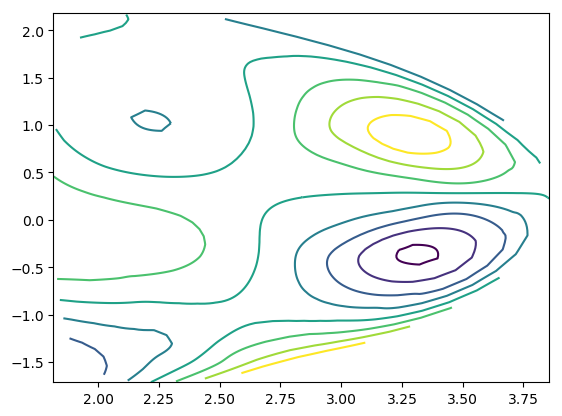

In [338]:
PyPlot.contour(pxr.X[:,:,1],pxr.Z[:,:,1], B1[:,:,1,1])
PyPlot.show()

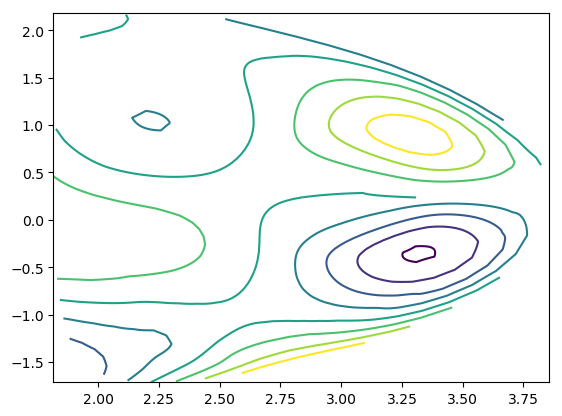

In [339]:
PyPlot.contour(pxr.X[:,:,1],pxr.Z[:,:,1], B1_created[:,:,1])
PyPlot.show()

In [340]:
function b2_an()
    b2_an = []
    for r in rn
        for u in un
            for t in tn
                append!(b2_an, -Interpolations.gradient(GAp_eint,r,u,t)[1])
            end
        end
    end
    b2_an = permutedims(reshape(b2_an,size(tn)[1],size(un)[1],size(rn)[1]),(3,2,1))
    return b2_an
end

b2_an (generic function with 1 method)

In [341]:
B2_created = b2_an();

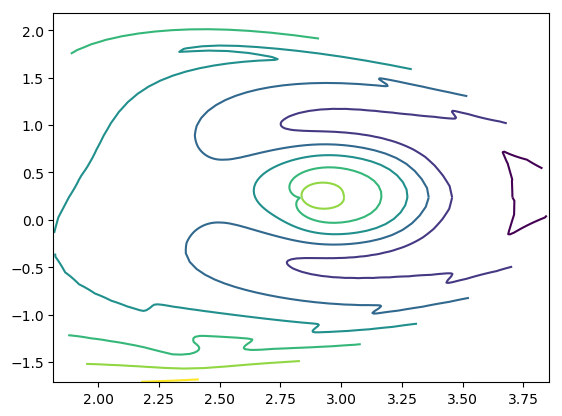

In [342]:
PyPlot.contour(pxr.X[:,:,1],pxr.Z[:,:,1], B2[:,:,1,1])
PyPlot.show()

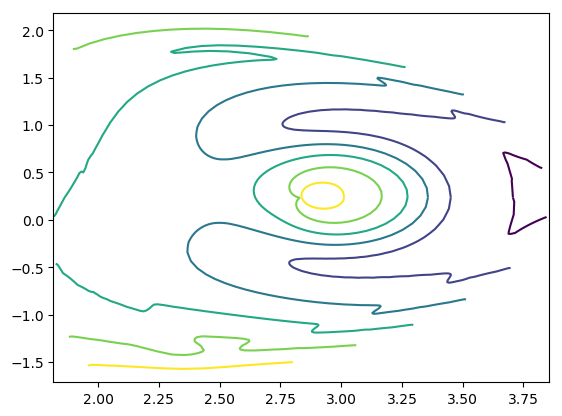

In [343]:
PyPlot.contour(pxr.X[:,:,1],pxr.Z[:,:,1], B2_created[:,:,1])
PyPlot.show()

In [344]:
function b3_an()
    b3_an = []
    for r in rn
        for u in un
            for t in tn
                append!(b3_an, Interpolations.gradient(GAu_eint,r,u,t)[1] -Interpolations.gradient(GAu_eint,r,u,t)[2])
            end
        end
    end
    b3_an = permutedims(reshape(b3_an,size(tn)[1],size(un)[1],size(rn)[1]),(3,2,1))
    return b3_an
end

b3_an (generic function with 1 method)

In [345]:
B3_created = b3_an();

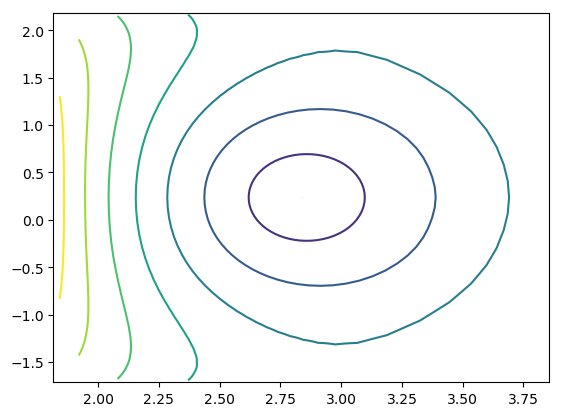

In [346]:
PyPlot.contour(pxr.X[:,:,1],pxr.Z[:,:,1], B3[:,:,1,1])
PyPlot.show()

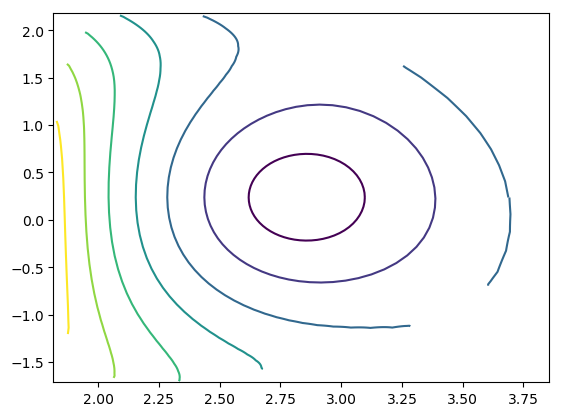

In [347]:
PyPlot.contour(pxr.X[:,:,1],pxr.Z[:,:,1], B3_created[:,:,1])
PyPlot.show()

## Define new functions for divergence-free field from analytic curl

In [351]:
function B1_df(r,u,t)
    return Interpolations.gradient(GAp_eint,r,u,t)[2]
end

B1_df (generic function with 1 method)

In [367]:
function B2_df(r,u,t)
    return -Interpolations.gradient(GAp_eint,r,u,t)[1]
end

B2_df (generic function with 1 method)

In [353]:
function B3_df(r,u,t)
    return Interpolations.gradient(GAu_eint,r,u,t)[1] -Interpolations.gradient(GAu_eint,r,u,t)[2]
end

B3_df (generic function with 1 method)

## Load and Spline metric tensor

In [167]:
metricpath = "/net/scratch3/giannis_kx/FTLE/11/shaped_metric_coeff3d.npz"

"/net/scratch3/giannis_kx/FTLE/11/shaped_metric_coeff3d.npz"

In [168]:
metric = npzread(metricpath);

In [169]:
grr = metric["grr_do"];
gtt = metric["gtt_do"];
grt = metric["grt_do"];
gpp = metric["gpp_do"];
grp = metric["grp_do"];
gtp = metric["gtp_do"];
radial_grid = metric["radial_grid"];
pol_grid = metric["pol_grid"];
tor_grid = metric["tor_grid"];
Jac_an = metric["Jacobian"];

In [170]:
rm = LinRange(radial_grid[1],radial_grid[end],size(radial_grid)[1]);
um = LinRange(pol_grid[1],pol_grid[end],size(pol_grid)[1]);
fm = LinRange(tor_grid[1],tor_grid[end],size(tor_grid)[1]);

In [171]:
grr_int = Interpolations.interpolate(grr, (BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));
gtt_int = Interpolations.interpolate(gtt, (BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));
gpp_int = Interpolations.interpolate(gpp, (BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));
grt_int = Interpolations.interpolate(grt, (BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));
grp_int = Interpolations.interpolate(grp, (BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));
gtp_int = Interpolations.interpolate(gtp, (BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));
Jac_an_int = Interpolations.interpolate(Jac_an, (BSpline(Cubic(Line(OnCell()))),BSpline(Cubic(Line(OnCell()))),BSpline(Cubic(Line(OnCell())))));

In [172]:
grr_sint = scale(grr_int,rm,um,fm);
gtt_sint = scale(gtt_int,rm,um,fm);
gpp_sint = scale(gpp_int,rm,um,fm);
grt_sint = scale(grt_int,rm,um,fm);
grp_sint = scale(grp_int,rm,um,fm);
gtp_sint = scale(gtp_int,rm,um,fm);
Jac_an_sint = scale(Jac_an_int,rm,um,fm);

In [173]:
grr_eint = extrapolate(grr_sint,(Line(),Line(),Line()));
gtt_eint = extrapolate(gtt_sint,(Line(),Line(),Line()));
gpp_eint = extrapolate(gpp_sint,(Line(),Line(),Line()));
grt_eint = extrapolate(grt_sint,(Line(),Line(),Line()));
grp_eint = extrapolate(grp_sint,(Line(),Line(),Line()));
gtp_eint = extrapolate(gtp_sint,(Line(),Line(),Line()));
Jac_an_eint = extrapolate(Jac_an_sint,(Line(),Line(),Line()));

In [174]:
grr = grr_eint(rn,un,phin);
grt = grt_eint(rn,un,phin);
gpp = gpp_eint(rn,un,phin);
gtt = gtt_eint(rn,un,phin);
grp = grp_eint(rn,un,phin);
gtp = gtp_eint(rn,un,phin);
Jac_an = Jac_an_eint(rn,un,phin);

In [175]:
grrc = grr_eint(rc,uc,phic);
grtc = grt_eint(rc,uc,phic);
gppc = gpp_eint(rc,uc,phic);
gttc = gtt_eint(rc,uc,phic);
grpc = grp_eint(rc,uc,phic);
gtpc = gtp_eint(rc,uc,phic);
Jac_anc = Jac_an_eint(rc,uc,phic);

## Field magnitude

In [181]:
JBc = sqrt.(B1c.*B1c.*grrc[:,:,:,na] .+ B2c.*B2c.*gttc[:,:,:,na] .+ B3c.*B3c.*gppc[:,:,:,na] .+ 2*B1c.*B2c.*grtc[:,:,:,na] .+ 2*B1c.*B3c.*grpc[:,:,:,na] .+ 2*B2c.*B3c.*gtpc[:,:,:,na]);

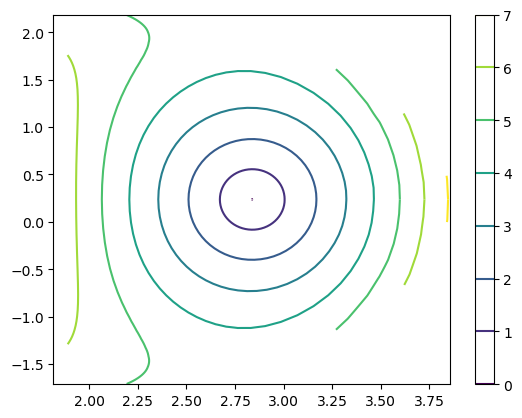

In [182]:
PyPlot.contour(pxr.X[:,:,1],pxr.Z[:,:,1],JB[:,:,16,1])
PyPlot.colorbar()
PyPlot.show()

In [183]:
JB_int = Interpolations.interpolate(JBc,(BSpline(Cubic(Line(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Line(OnGrid())))));

In [184]:
JB_sint = scale(JB_int,rc,uc,phic,tn);

In [185]:
JB_eint = extrapolate(JB_sint, (Line(),Periodic(),Periodic(),Line()));

In [186]:
JB = JB_eint(rn,un,phin,tn);

## Cartesian maps

In [187]:
X_int = Interpolations.interpolate(pxr.X,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Periodic(OnGrid())))));
Y_int = Interpolations.interpolate(pxr.Y,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Periodic(OnGrid())))));
Z_int = Interpolations.interpolate(pxr.Z,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Periodic(OnGrid())))));

In [188]:
X_sint = scale(X_int, rn,un,phin);
Y_sint = scale(Y_int, rn,un,phin);
Z_sint = scale(Z_int, rn,un,phin);

In [189]:
X_eint = extrapolate(X_sint, (Line(),Periodic(),Periodic()));
Y_eint = extrapolate(Y_sint, (Line(),Periodic(),Periodic()));
Z_eint = extrapolate(Z_sint, (Line(),Periodic(),Periodic()));

## Integrator

In [223]:
function Field_line_VP!(du,u,p,t)
    du[1] = B1_eint(u[1],u[2],u[3],p[1])
    du[2] = B2_eint(u[1],u[2],u[3],p[1])
    du[3] = B3_eint(u[1],u[2],u[3],p[1])
end

function condition_cross(u,t,integrator)
    u[3] - integrator.p[2]*2.0*pi
end
function count_cross!(integrator)
    integrator.p[2] = integrator.p[2]+1
end

cb1 = ContinuousCallback(condition_cross,count_cross!,rootfind = true,save_positions=(false,true))

function field_line_integration(rs::Float64,us::Float64,time::Int)
    #poinc = [0.0,0.0]
    u0 = [rs,us,0.0]
    p = [time,1]
    tspan = (0.0,1080.0)
    prob = ODEProblem(Field_line!,u0,tspan,p)
    #cbs = CallbackSet(cb1,cb2)
    #integrator = init(prob,VCAB4(),callback=cb1,reltol=1.e-10,abstol=1.e-10)
    sol = solve(prob,CVODE_BDF(),callback = cb1, reltol=1.e-10,abstol=1.e-10,save_everystep=false,save_start=false, save_end=false)
    return sol
end

field_line_integration (generic function with 1 method)

In [309]:
function Field_line!(du,u,p,t)
    du[1] = B1_eint(u[1],u[2],u[3],p[1])/JB_eint(u[1],u[2],u[3],p[1])
    du[2] = B2_eint(u[1],u[2],u[3],p[1])/JB_eint(u[1],u[2],u[3],p[1])
    du[3] = B3_eint(u[1],u[2],u[3],p[1])/JB_eint(u[1],u[2],u[3],p[1])
end

function condition_cross(u,t,integrator)
    u[3] - integrator.p[2]*2.0*pi
end
function count_cross!(integrator)
    integrator.p[2] = integrator.p[2]+1
end

cb1 = ContinuousCallback(condition_cross,count_cross!,rootfind = true,save_positions=(false,true))

function field_line_integration_VP(rs::Float64,us::Float64,time::Int)
    #poinc = [0.0,0.0]
    u0 = [rs,us,0.0]
    p = [time,1]
    tspan = (0.0,1080.0)
    prob = ODEProblem(Field_line_VP!,u0,tspan,p)
    #cbs = CallbackSet(cb1,cb2)
    #integrator = init(prob,VCAB4(),callback=cb1,reltol=1.e-10,abstol=1.e-10)
    #sol = solve(prob,CVODE_Adams(), reltol=1.e-10,abstol=1.e-10,save_everystep=false,save_start=false, save_end=false)
    sol = solve(prob,BS5(), reltol=1.e-10,abstol=1.e-10)
    return sol
end

field_line_integration_VP (generic function with 1 method)

In [357]:
function Field_line_oo!(du,u,p,t)
    du[1] = B1ct_eint(u[1],u[2],p[1])
    du[2] = B2ct_eint(u[1],u[2],p[1])
    du[3] = B3ct_eint(u[1],u[2],p[1])
end

function condition_cross(u,t,integrator)
    u[3] - integrator.p[2]*2.0*pi
end
function count_cross!(integrator)
    integrator.p[2] = integrator.p[2]+1
end

cb1 = ContinuousCallback(condition_cross,count_cross!,rootfind = true,save_positions=(false,true))

function field_line_integration_oo(rs::Float64,us::Float64,time::Int)
    #poinc = [0.0,0.0]
    u0 = [rs,us,0.0]
    p = [time,1]
    tspan = (0.0,1080.0)
    prob = ODEProblem(Field_line_oo!,u0,tspan,p)
    #cbs = CallbackSet(cb1,cb2)
    #integrator = init(prob,VCAB4(),callback=cb1,reltol=1.e-10,abstol=1.e-10)
    sol = solve(prob,BS5(),dt=0.1,callback = cb1, reltol=1.e-10,abstol=1.e-10,save_everystep=false,save_start=false, save_end=false)
    return sol
end

field_line_integration_oo (generic function with 1 method)

## Integrator with n=0, divergence-free field

In [425]:
function Field_line_df!(du,u,p,t)
    du[1] = B1_df(u[1],u[2],p[1])
    du[2] = B2_df(u[1],u[2],p[1])
    du[3] = B3_df(u[1],u[2],p[1])
end

function condition_cross(u,t,integrator)
    u[3] - integrator.p[2]*2.0*pi
end
function count_cross!(integrator)
    integrator.p[2] = integrator.p[2]+1
end

cb1 = ContinuousCallback(condition_cross,count_cross!,rootfind = true,save_positions=(false,true))

function field_line_integration_df(rs::Float64,us::Float64,time::Float64)
    #poinc = [0.0,0.0]
    u0 = [rs,us,0.0]
    p = [time,1]
    tspan = (0.0,1080.0)
    prob = ODEProblem(Field_line_df!,u0,tspan,p)
    #cbs = CallbackSet(cb1,cb2)
    #integrator = init(prob,VCAB4(),callback=cb1,reltol=1.e-10,abstol=1.e-10)
    sol = solve(prob,BS5(),callback = cb1, reltol=1.e-8,abstol=1.e-10,save_everystep=false,save_start=false, save_end=false)
    return sol
end

field_line_integration_df (generic function with 2 methods)

In [408]:
gr()

Plots.GRBackend()

In [426]:
@btime soldf = field_line_integration_df(0.4,0.0,1);

  209.458 ms (3612603 allocations: 71.55 MiB)


In [415]:
soldf = field_line_integration_df(0.4,0.0,1);

In [427]:
xsdf = [X_eint(soldf[1,i],soldf[2,i],0) for i in 1:length(soldf.t)];
ysdf = [Y_eint(soldf[1,i],soldf[2,i],0) for i in 1:length(soldf.t)];
zsdf = [Z_eint(soldf[1,i],soldf[2,i],0) for i in 1:length(soldf.t)];

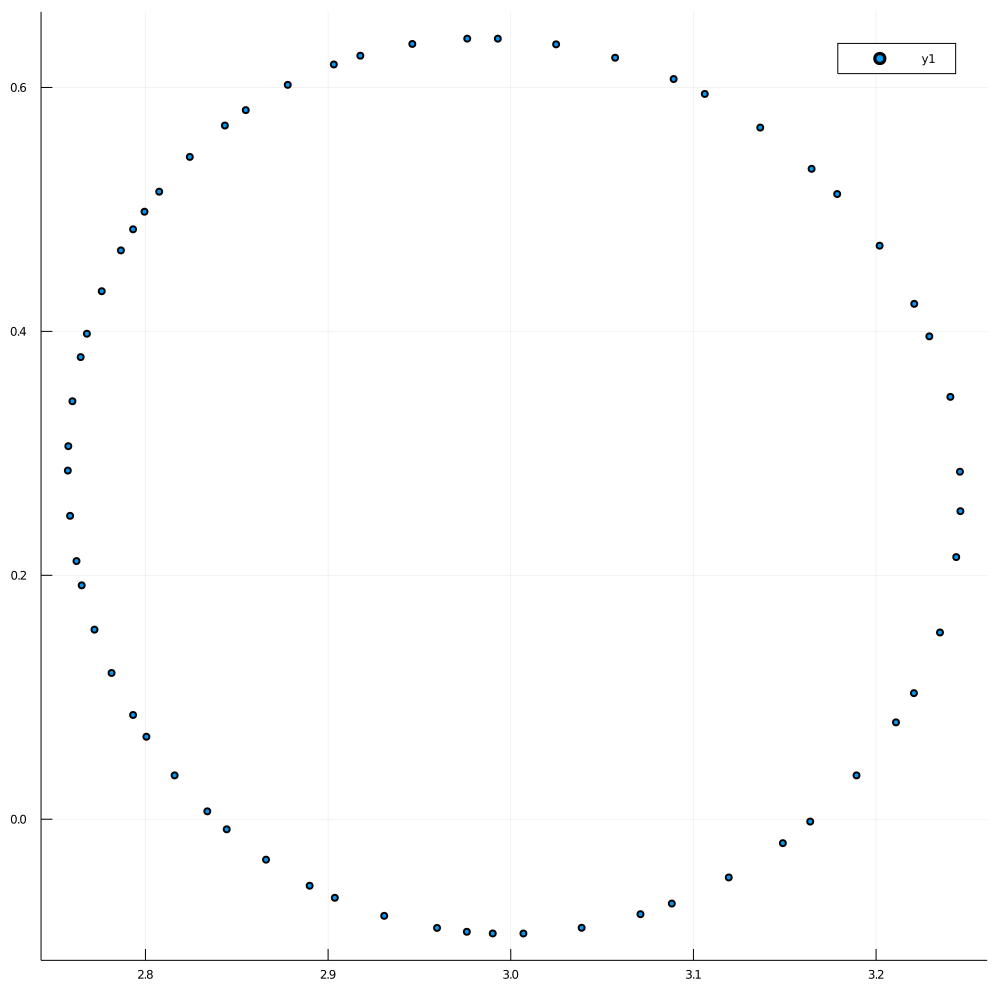

In [428]:
#Plots.scatter(xs,ys,zs,lw=2,camera = (0,45))
Plots.scatter(xsdf,zsdf)
#Plots.scatter(sol[1,:],sol[2,:])

In [317]:
sol = field_line_integration_oo(0.4,0.0,1);

In [318]:
xs = [X_eint(sol[1,i],sol[2,i],0) for i in 1:length(sol.t)];
ys = [Y_eint(sol[1,i],sol[2,i],0) for i in 1:length(sol.t)];
zs = [Z_eint(sol[1,i],sol[2,i],0) for i in 1:length(sol.t)];

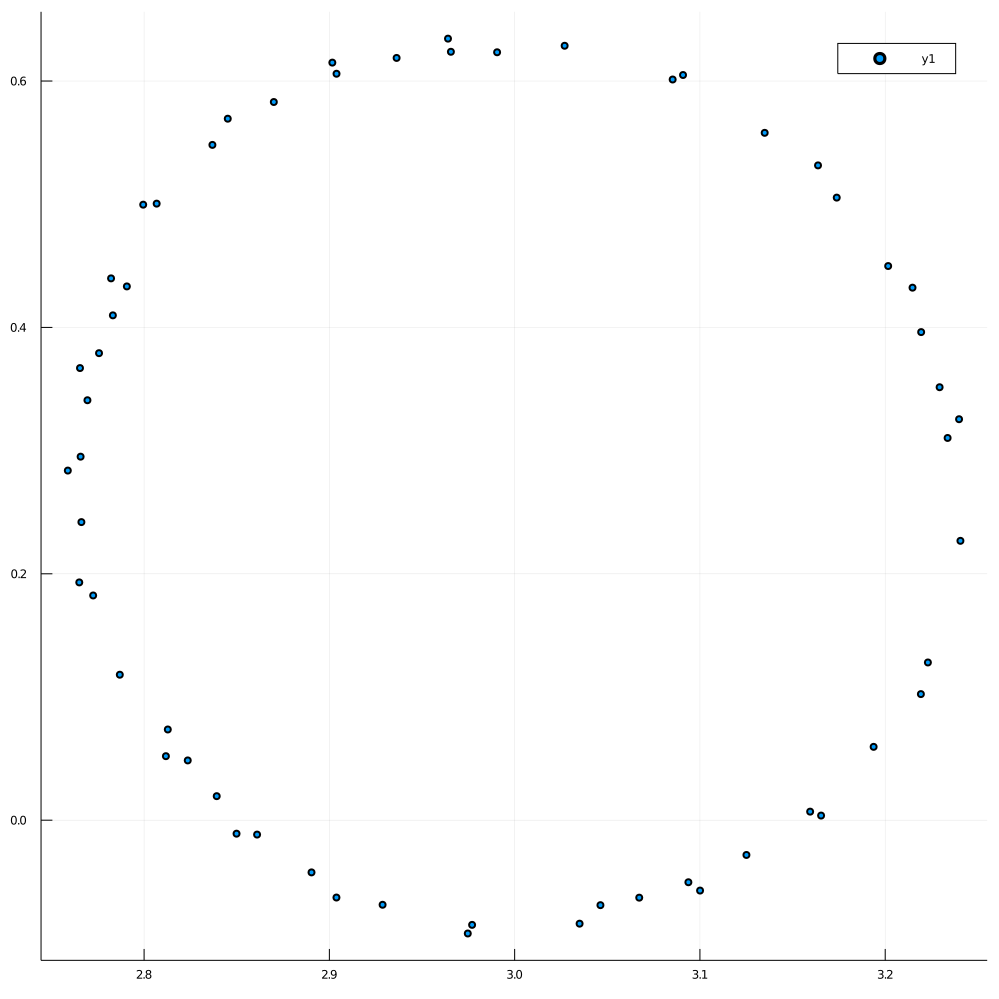

In [319]:
#Plots.scatter(xs,ys,zs,lw=2,camera = (0,45))
Plots.scatter(xs,zs)
#Plots.scatter(sol[1,:],sol[2,:])

In [263]:
sol2 = field_line_integration_VP(0.4,0.0,1);

In [264]:
xs2 = [X_eint(sol2[1,i],sol2[2,i],0) for i in 1:length(sol2.t)];
ys2 = [Y_eint(sol2[1,i],sol2[2,i],0) for i in 1:length(sol2.t)];
zs2 = [Z_eint(sol2[1,i],sol2[2,i],0) for i in 1:length(sol2.t)];

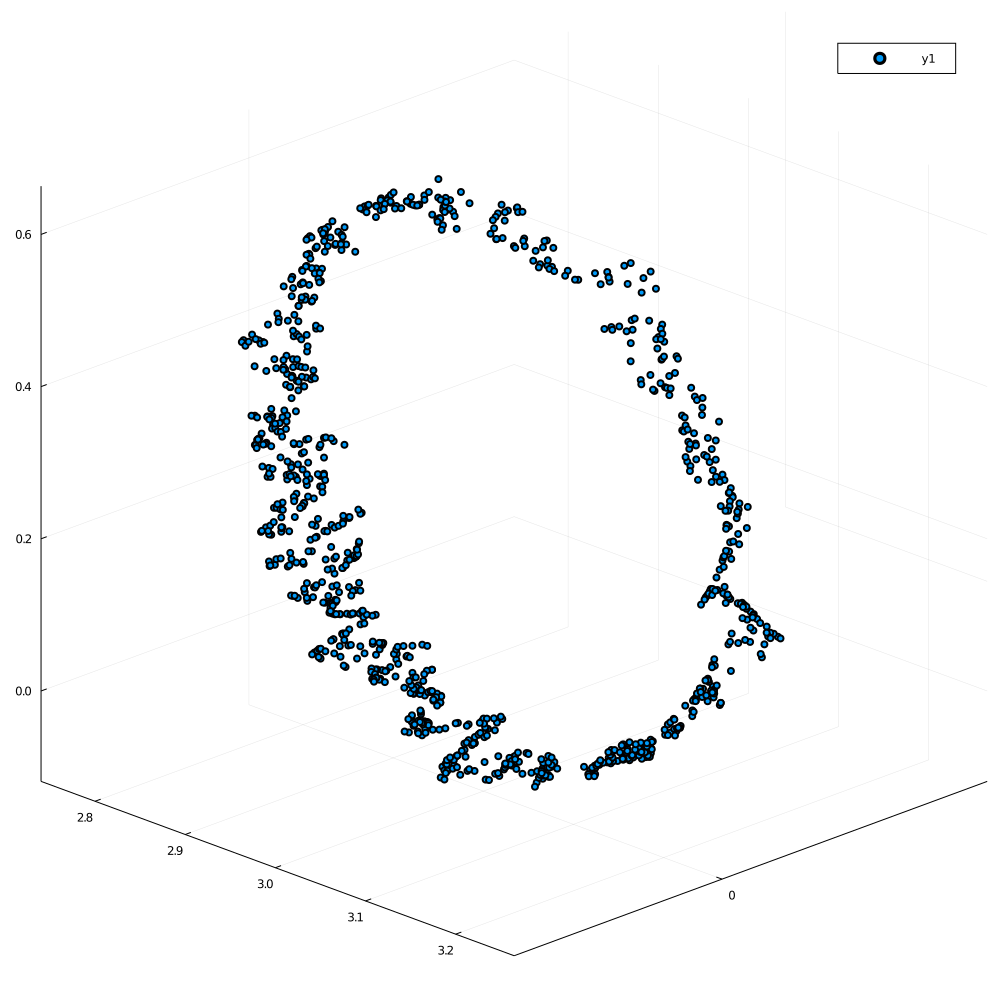

┌ Warning: No strict ticks found
└ @ PlotUtils /users/giannis_kx/.julia/packages/PlotUtils/es5pb/src/ticks.jl:283
┌ Warning: No strict ticks found
└ @ PlotUtils /users/giannis_kx/.julia/packages/PlotUtils/es5pb/src/ticks.jl:283


In [268]:
Plots.scatter(xs2,ys2,zs2,lw=2,camera = (45,45))
#Plots.scatter(xs2,zs2)
#Plots.scatter(sol2[1,:],sol2[2,:])

In [233]:
sol3 = field_line_integration_oo(0.4,0.0,1);

In [234]:
xs3 = [X_eint(sol3[1,i],sol3[2,i],0) for i in 1:length(sol3.t)];
ys3 = [Y_eint(sol3[1,i],sol3[2,i],0) for i in 1:length(sol3.t)];
zs3 = [Z_eint(sol3[1,i],sol3[2,i],0) for i in 1:length(sol3.t)];

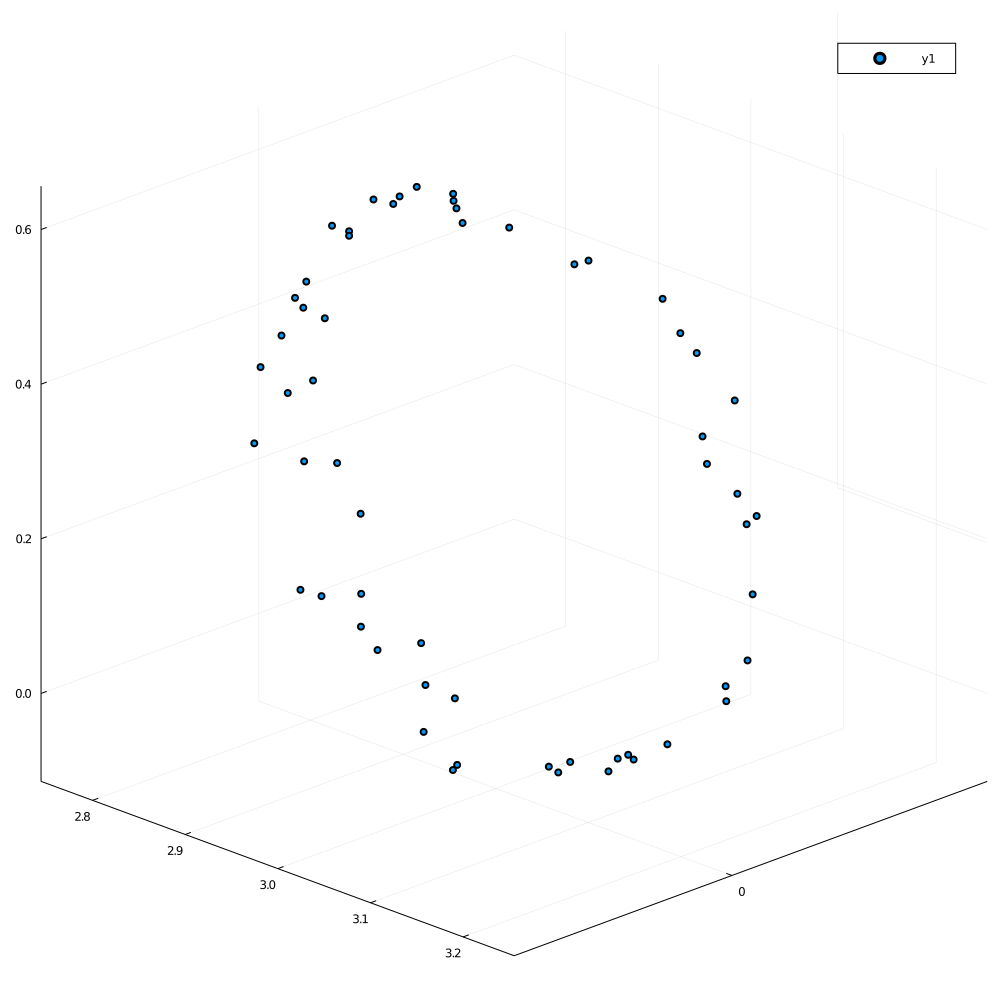

┌ Warning: No strict ticks found
└ @ PlotUtils /users/giannis_kx/.julia/packages/PlotUtils/es5pb/src/ticks.jl:283
┌ Warning: No strict ticks found
└ @ PlotUtils /users/giannis_kx/.julia/packages/PlotUtils/es5pb/src/ticks.jl:283


In [238]:
Plots.scatter(xs3,ys3,zs3,lw=2,camera = (45,45))
#Plots.scatter(xs3,zs3)
#Plots.scatter(sol3[1,:],sol3[2,:])

In [383]:
function Poincare_Map(N::Int)
    ic = LinRange(0.02,0.9,N)
    r = [[] for i in 1:N]
    theta = [[] for i in 1:N]
    phi = [[] for i in 1:N]
    for i in 1:N
        sol = field_line_integration_df(ic[i],0.0,1)
        r[i] = sol[1,:]
        theta[i] = sol[2,:]
        phi[i] = sol[3,:]
    end
    xx = [[] for i in 1:N]
    zz = [[] for i in 1:N]
    for i in 1:N
        xcoord = [X_eint(r[i][j],theta[i][j],0) for j in 1:length(r[i])]
        zcoord = [Z_eint(r[i][j],theta[i][j],0) for j in 1:length(r[i])]
        xx[i] = xcoord
        zz[i] = zcoord
    end
    return xx,zz
end

Poincare_Map (generic function with 1 method)

In [393]:
using BenchmarkTools

LoadError: [91mArgumentError: Package BenchmarkTools not found in current path:[39m
[91m- Run `import Pkg; Pkg.add("BenchmarkTools")` to install the BenchmarkTools package.[39m


In [384]:
xx,zz = Poincare_Map(8);

In [245]:
gr(size=(1000,1000), html_output_format=:png)

Plots.GRBackend()

In [385]:
Plots.plot();

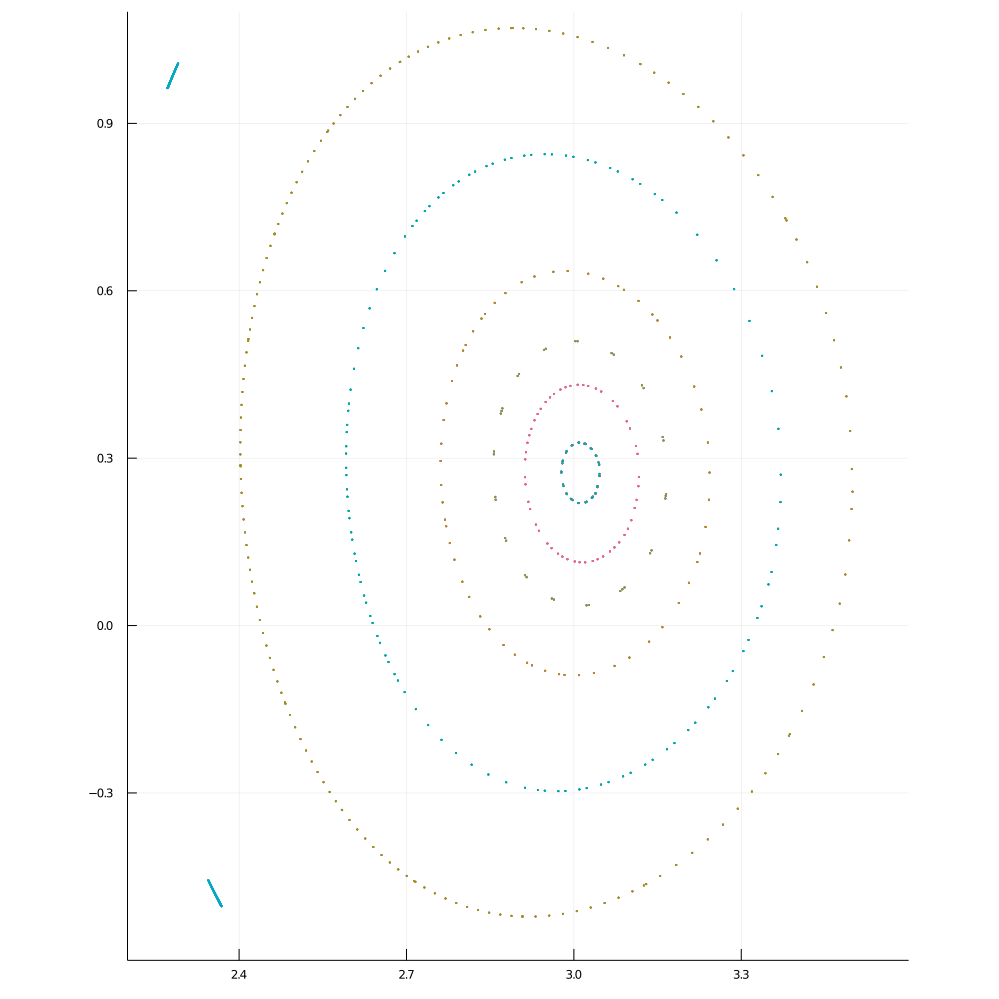

In [392]:
for i in 1:8
    Plots.scatter!(xx[i],zz[i],markerstrokewidth=0,markersize=1.9,legend=false,aspect_ratio=:equal,xlims=(2.2,3.6),ylims=(-0.6,1.1
            ))
end
current()

In [56]:
size(xx[4])

(383,)

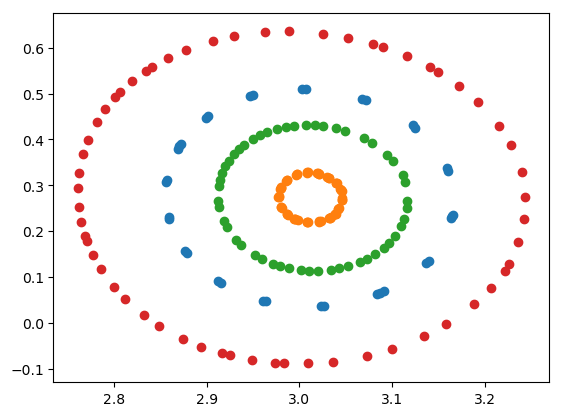

In [387]:
for i in 1:4
    PyPlot.scatter(xx[i][:],zz[i][:])
end
PyPlot.show()

In [38]:
sol1 = field_line_integration(0.9,0.0,1);
soloo = field_line_integration_oo(0.,0.0,1);

#sol3 = field_line_integration(0.6,0.0,1);
#sol4 = field_line_integration(0.8,0.0,1);

In [41]:
xsol1 = [X_eint(sol1[1,i],sol1[2,i],sol1[3,i]) for i in 1:length(sol1.t)];
ysol1 = [Y_eint(sol1[1,i],sol1[2,i],sol1[3,i]) for i in 1:length(sol1.t)];
zsol1 = [Z_eint(sol1[1,i],sol1[2,i],sol1[3,1]) for i in 1:length(sol1.t)];

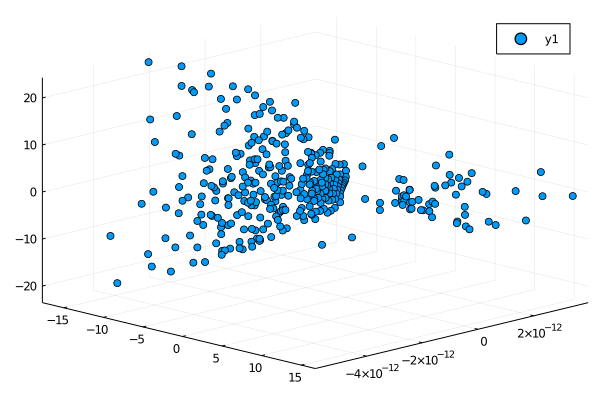

In [43]:
Plots.scatter(xsol1,ysol1,zsol1,camera = (45,45))

In [80]:
xp1 = [X_eint(sol1[1,i],sol1[2,i],0) for i in 1:length(sol1.t)];
yp1 = [Y_eint(sol1[1,i],sol1[2,i],0) for i in 1:length(sol1.t)];
zp1 = [Z_eint(sol1[1,i],sol1[2,i],0) for i in 1:length(sol1.t)];
xpoo = [X_eint(soloo[1,i],soloo[2,i],0) for i in 1:length(soloo.t)];
ypoo = [Y_eint(soloo[1,i],soloo[2,i],0) for i in 1:length(soloo.t)];
zpoo = [Z_eint(soloo[1,i],soloo[2,i],0) for i in 1:length(soloo.t)];
#xp3 = [X_eint(sol3[1,i],sol3[2,i],0) for i in 1:length(sol3.t)];
#yp3 = [Y_eint(sol3[1,i],sol3[2,i],0) for i in 1:length(sol3.t)];
#zp3 = [Z_eint(sol3[1,i],sol3[2,i],0) for i in 1:length(sol3.t)];
#xp4 = [X_eint(sol4[1,i],sol4[2,i],0) for i in 1:length(sol4.t)];
#yp4 = [Y_eint(sol4[1,i],sol4[2,i],0) for i in 1:length(sol4.t)];
#zp4 = [Z_eint(sol4[1,i],sol4[2,i],0) for i in 1:length(sol4.t)];

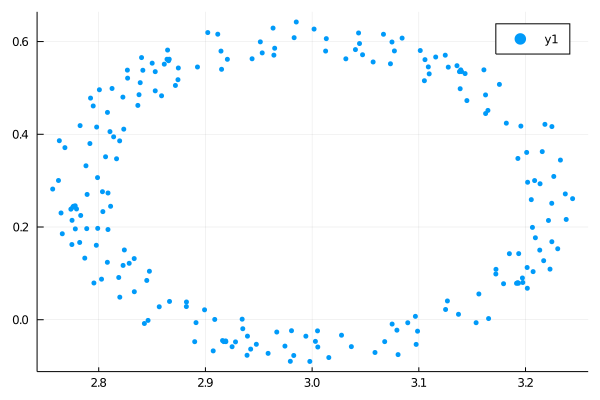

In [90]:
Plots.scatter()
Plots.scatter(xp1,zp1,markerstrokewidth=0,markersize=2.9)#,xlim=(2.9,3.1),ylim=(0.5,0.7))
#Plots.scatter!(xpVP,zpVP,markerstrokewidth=0,markersize=1.9,xlim=(2.9,3.1),ylim=(0.5,0.7))
#Plots.scatter!(xp3,zp3,markerstrokewidth=0,markersize=1.9)
#Plots.scatter!(xp4,zp4,markerstrokewidth=0,markersize=1.9)

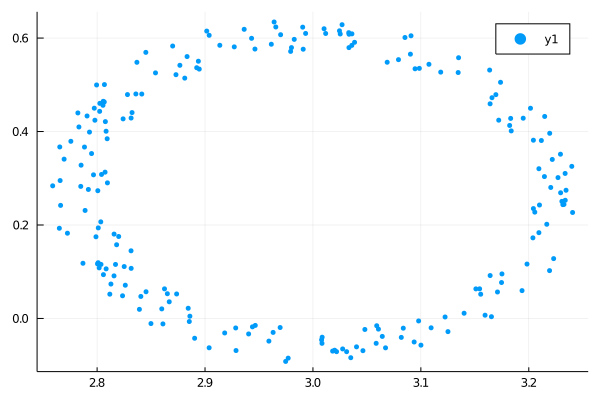

In [91]:
Plots.scatter(xpoo,zpoo,markerstrokewidth=0,markersize=2.9)#,xlim=(2.9,3.1),ylim=(0.5,0.7))

In [170]:
function dAdr(arr::Array{Float64,4},theta::Int,phi::Int,t::Int)
    dr = 1.0 / size(arr,1)
    p = arr[:,theta,phi,t]
    if theta<33
        mid = theta + convert(Int,(size(arr,2)-1)/2)
    else
        mid = theta - convert(Int,(size(arr,2)-1)/2)
    end
    p_pi = arr[:,mid,phi,t]
    L = length(p)
    dpsidr = zeros(L)
    for i in range(1,stop=L)
        if i==1
            dpsidr[i] = (-p[3]+8*p[2]-8*p_pi[2]+p_pi[3])/(12.0*dr)
        elseif i==2
            dpsidr[i] = (-p[4]+8*p[3]-8*p[1]+p_pi[2])/(12.0*dr)
        elseif i==L-1
            dpsidr[i] = (p[L]-p[L-2])/(2.0*dr)
        elseif i==L-2 
            dpsidr[i] = (-p[L]+8*p[L-1]-8*p[L-3]+p[L-4])/(12.0*dr)
        elseif i==L
            dpsidr[i] = (p[L]-p[L-1])/dr
        else
            dpsidr[i] = (-p[i+2]+8*p[i+1]-8*p[i-1]+p[i-2])/(12.0*dr)
        end
    end
    return dpsidr
end

function dAdt(arr::Array{Float64,4},r::Int,phi::Int,t::Int)
    dtheta = 2.0*pi / size(arr,2)
    p = arr[r,:,phi,t]
    L = length(p)
    dpsidtheta = zeros(L)
    for i in range(1,stop=L)
        if i==1
            dpsidtheta[i] = (-p[3]+8*p[2]-8*p[L-1]+p[L-2])/(12.0*dtheta)
        elseif i==2
            dpsidtheta[i] = (-p[4]+8*p[3]-8*p[1]+p[L-1])/(12.0*dtheta)
        elseif i==L-1
            dpsidtheta[L-1] = (-p[2]+8*p[1]-8*p[L-2]+p[L-3])/(12.0*dtheta)
        elseif i==L-2
            dpsidtheta[L-2] = (-p[1]+8*p[L-1]-8*p[L-3]+p[L-4])/(12.0*dtheta)
        elseif i==L
            dpsidtheta[L] = dpsidtheta[1]
        else
            dpsidtheta[i] = (-p[i+2]+8*p[i+1]-8*p[i-1]+p[i-2])/(12.0*dtheta)
        end
    end
    return dpsidtheta
end 

function dAdphi(arr::Array{Float64,4},r::Int,theta::Int,t::Int)
    dphi = 2.0*pi / size(arr,3)
    p = arr[r,theta,:,t]
    L = length(p)
    dpsidphi = zeros(L)
    for i in range(1,stop=L)
        if i==1
            dpsidphi[i] = (-p[3]+8*p[2]-8*p[L-1]+p[L-2])/(12.0*dphi)
        elseif i==2
            dpsidphi[i] = (-p[4]+8*p[3]-8*p[1]+p[L-1])/(12.0*dphi)
        elseif i==L-1
            dpsidphi[L-1] = (-p[2]+8*p[1]-8*p[L-2]+p[L-3])/(12.0*dphi)
        elseif i==L-2
            dpsidphi[L-2] = (-p[1]+8*p[L-1]-8*p[L-3]+p[L-4])/(12.0*dphi)
        elseif i==L
            dpsidphi[L] = dpsidphi[1]
        else
            dpsidphi[i] = (-p[i+2]+8*p[i+1]-8*p[i-1]+p[i-2])/(12.0*dphi)
        end
    end
    return dpsidphi
end 


function dpsi_dr(arr::Array{Float64,4})
    r_deriv = Float64[] 
    for theta in range(1,stop=size(arr,2))
        for phi in range(1,stop=size(arr,3))
            for t in range(1,stop=size(arr,4))
                r_deriv = append!(r_deriv,dAdr(arr,theta,phi,t))
            end
        end
    end
     # In Julia the convention in reshape is the opposite of Python
    return permutedims(reshape(r_deriv,(size(arr,1),size(arr,4),size(arr,3),size(arr,2))),(1,4,3,2))
end

function dpsi_dtheta(arr::Array{Float64,4})
    t_deriv = Float64[] 
    for r in range(1,stop=size(arr,1))
        for phi in range(1,stop=size(arr,3))
            for t in range(1,stop=size(arr,4))
                t_deriv = append!(t_deriv,dAdt(arr,r,phi,t))
            end
        end
    end
    return permutedims(reshape(t_deriv,(size(arr,2),size(arr,4),size(arr,3),size(arr,1))),(4,1,3,2))
end

function dpsi_dphi(arr::Array{Float64,4})
    phi_deriv = Float64[] 
    for r in range(1,stop=size(arr,1))
        for theta in range(1,stop=size(arr,2))
            for t in range(1,stop=size(arr,4))
                phi_deriv = append!(phi_deriv,dAdphi(arr,r,theta,t))
            end
        end
    end
    return permutedims(reshape(phi_deriv,(size(arr,3),size(arr,4),size(arr,2),size(arr,1))),(4,3,1,2))
end

dpsi_dphi (generic function with 1 method)

In [171]:
dB1dr = dpsi_dr(B1);
dB2dtheta = dpsi_dtheta(B2);
dB3dphi = dpsi_dphi(B3);

In [172]:
divB = dB1dr .+ dB2dtheta .+ dB3dphi;

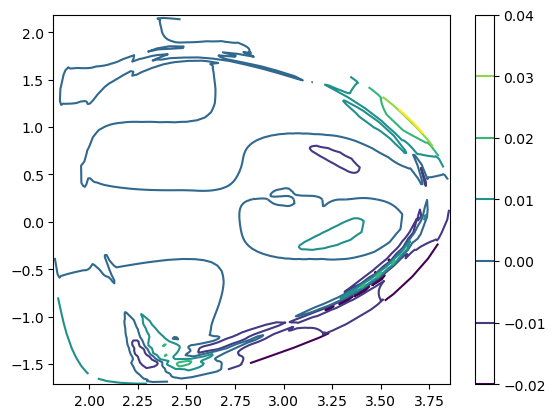

In [173]:
PyPlot.contour(pxr.X[:,:,1],pxr.Z[:,:,1],divB[:,:,1,1])
PyPlot.colorbar()
PyPlot.show()

In [174]:
divB_int = Interpolations.interpolate(divB,(BSpline(Cubic(Line(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Periodic(OnCell()))),BSpline(Cubic(Line(OnGrid())))));

In [175]:
divB_sint = scale(divB_int,rn,un,phin,tn);

In [176]:
divB_eint = extrapolate(divB_sint, (Line(),Periodic(),Periodic(),Line()));

In [217]:
list = [[] for i in 1:4]

4-element Array{Array{Any,1},1}:
 []
 []
 []
 []

## Check for $\delta B^{\phi}$

In [28]:
size(B3c)

(128, 64, 32, 5)

In [29]:
db3 = B3ct[:,:,1] .- B3c[:,:,1,1]; 

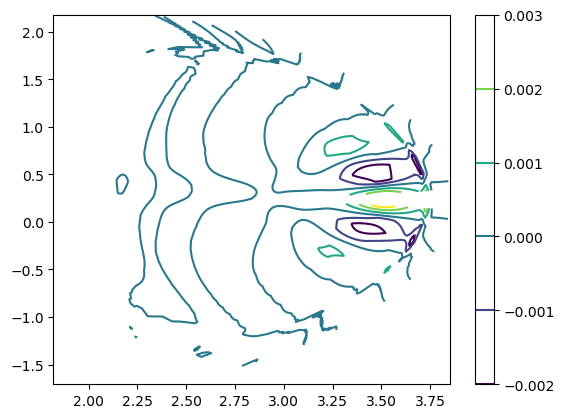

In [30]:
PyPlot.contour(pxr.Xc[:,:,1],pxr.Zc[:,:,1],db3)
PyPlot.colorbar()
PyPlot.show()

In [31]:
db3ovB3 = (B3ct[:,:,1] .- B3c[:,:,1,1])./B3ct[:,:,1]; 

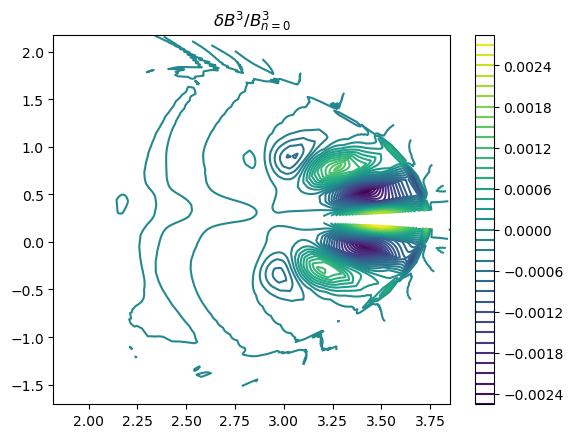

In [36]:
PyPlot.contour(pxr.Xc[:,:,1],pxr.Zc[:,:,1],db3ovB3,40)
PyPlot.title(L"$\delta B^{3}/B_{n=0}^{3}$")
PyPlot.colorbar()
PyPlot.show()

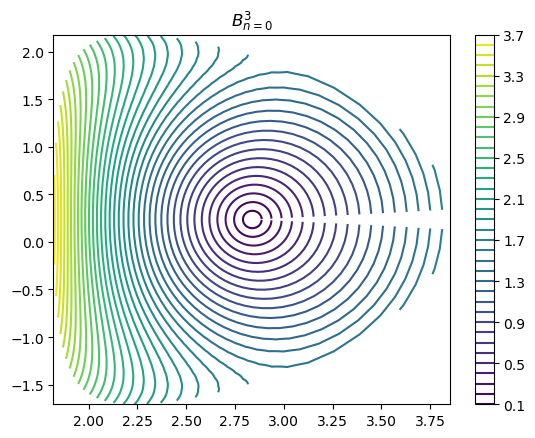

In [35]:
PyPlot.contour(pxr.Xc[:,:,1],pxr.Zc[:,:,1],B3ct[:,:,1],40)
PyPlot.title(L"$B_{n=0}^{3}$")
PyPlot.colorbar()
PyPlot.show()

In [394]:
using Pkg

In [395]:
Pkg.add("BenchmarkTools")

  Resolving package versions...
  Installed BenchmarkTools ─ v1.1.1
Updating `/turquoise/users/giannis_kx/.julia/environments/v1.5/Project.toml`
  [6e4b80f9] + BenchmarkTools v1.1.1
Updating `/turquoise/users/giannis_kx/.julia/environments/v1.5/Manifest.toml`
  [6e4b80f9] + BenchmarkTools v1.1.1


In [396]:
using BenchmarkTools

┌ Info: Precompiling BenchmarkTools [6e4b80f9-dd63-53aa-95a3-0cdb28fa8baf]
└ @ Base loading.jl:1278
